<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dependencies</a></span></li><li><span><a href="#Scraping" data-toc-modified-id="Scraping-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scraping</a></span></li><li><span><a href="#Analyzing" data-toc-modified-id="Analyzing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyzing</a></span></li><li><span><a href="#Vizzing" data-toc-modified-id="Vizzing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Vizzing</a></span></li></ul></div>

## Dependencies

In [43]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

## Scraping

In [68]:
def trumpInTitle(title):
    trumpArray = ['Trump', 'President', 'president', 'Donald']
    title = title.replace("'", ' ')
    title = title.replace('-', ' ')
    wordlist = title.split(' ')
    for word in wordlist:
        if word in trumpArray:
            return True
    return False

def addChannelToDf(soup, key, df):
    items = soup.find_all("h3", {"class":"yt-lockup-title"})
    meta = soup.find_all("ul", {"class":"yt-lockup-meta-info"})
    for i in range(0, len(items)):
        title = items[i].find('a')['title']
        views = meta[i].find('li').text.strip().split(' ')[0].replace('.', '')
        df = df.append({'show':key, 'title':title, 'views':views, 'trumpInTitle': trumpInTitle(title)}, ignore_index=True)
    return df

In [69]:
#Running time: about 4seconds per channel
df = pd.DataFrame(columns=['show', 'title', 'views', 'trumpInTitle'])
urls = {'Colbert': 'https://www.youtube.com/channel/UCMtFAi84ehTSYSE9XoHefig/videos',
        'Daily Show': 'https://www.youtube.com/channel/UCwWhs_6x42TyRM4Wstoq8HA/videos',
       'Seth Meyers': 'https://www.youtube.com/user/LateNightSeth/videos',
       'FOX': 'https://www.youtube.com/user/FoxNewsChannel/videos',
       'CNN':'https://www.youtube.com/user/CNN/videos',
       'MSNBC':'https://www.youtube.com/user/msnbcleanforward/videos',
       'ABC': 'https://www.youtube.com/user/ABCNews/videos',
       'NBC': 'https://www.youtube.com/user/NBCNews/videos'
       }
for key in urls:
    soup = BeautifulSoup(requests.get(urls[key]).content, "lxml")
    df = addChannelToDf(soup, key, df)


## Analyzing

In [70]:
#print(df[['title', 'trumpInTitle']])
avgDF = pd.DataFrame(columns=['show', 'TotalViewWith', 'TotalWith', 'TotalViewWithout', 'TotalWithout'])
df[['views']] = df[['views']].apply(pd.to_numeric)
for key in urls:
    totalViewWith = 0
    totalWith = 0
    totalViewWithout = 0
    totalWithout = 0
    for index, row in df.iterrows():
        if row['show'] == key:
            if row['trumpInTitle'] == True:
                totalWith += 1
                totalViewWith += row['views']
            else:
                totalWithout += 1
                totalViewWithout += row['views']
    avgDF = avgDF.append({'show':key, 'TotalViewWith':totalViewWith, 'TotalWith':totalWith, 'TotalViewWithout':totalViewWithout, 'TotalWithout':totalWithout}, ignore_index=True)
    

In [71]:
#calculating averages
avgDF['avgWith'] = avgDF.apply(lambda x: x['TotalViewWith']/x['TotalWith'], axis=1)
avgDF['avgWithout'] = avgDF.apply(lambda x: x['TotalViewWithout']/x['TotalWithout'], axis=1)
avgDF.set_index('show', inplace=True)

## Vizzing

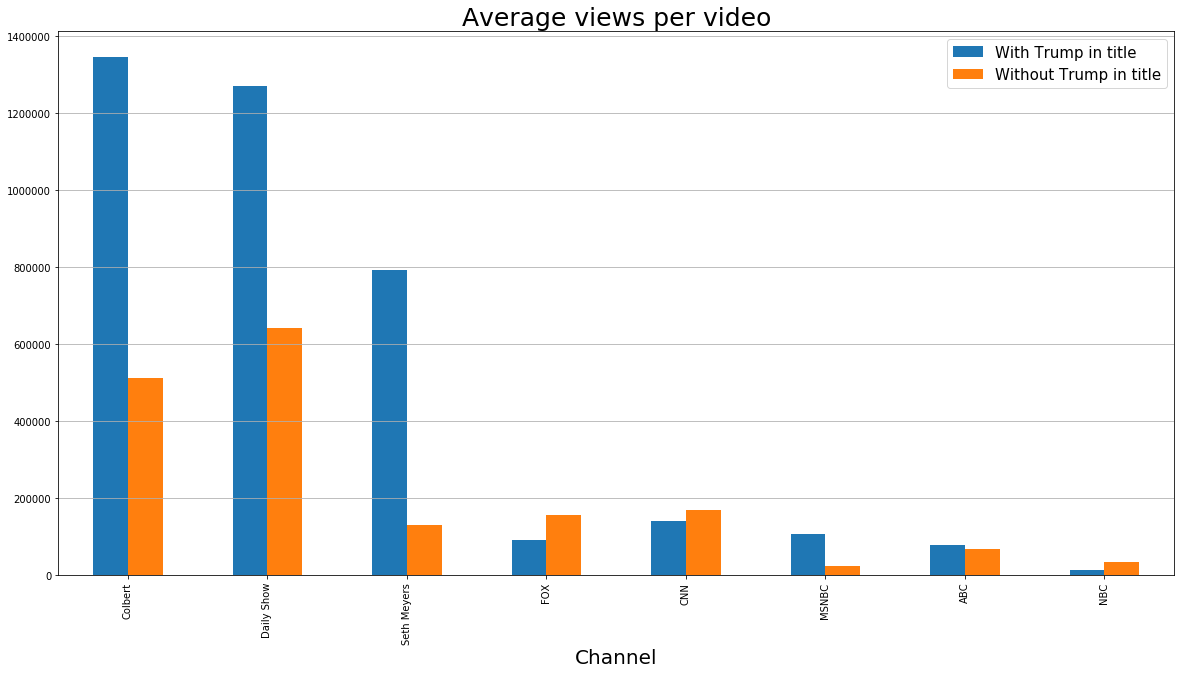

In [73]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
avgDF[['avgWith', 'avgWithout']].plot(kind='bar', ax=ax)

plt.title('Average views per video', size=25)
ax.legend(['With Trump in title', 'Without Trump in title'], loc='upper right', prop={'size':15})
ax.set_xlabel('Channel', size=20)
plt.grid(which='major', axis='y')
#plt.savefig('png/trumpviews.png')
plt.show()